# A Very Simple Neural Network for MNIST Data

Import all necessary modules

In [1]:
import sys
from time import ctime, time
if sys.version_info < (3,6):
    raise Exception('This notebook runs with Python 3.6 and higher!')
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mnist

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Lambda
from keras.regularizers import l2,l1
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.initializers import zeros,glorot_uniform
from keras.backend import one_hot, mean
from keras.callbacks import BaseLogger, Callback, LearningRateScheduler

import tensorflow as tf
from IPython.display import clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,8)            
tf.logging.set_verbosity(tf.logging.ERROR)
np.random.seed(1)


Using TensorFlow backend.


In [2]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def imgshow(X, Y, index):
    img = X[index].copy().reshape(28,28)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(img, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    fig.text(.5, .08, f'Classified as {Y[index].nonzero()[0][0]}', 
             ha='center',
            fontsize=15)
    plt.show()
    
    
class LearningRateCallBack(LearningRateScheduler):
    def __init__(self,lrlist):
        """
            learningrate : the learning rate for the model
            lrlist : A np.arrays of shape (n,2) 
                    the 1st col is filled with epoch noumbers and the 2nd col is
                    the associated lr
            
        """
        self.lrlist = lrlist
        
    def on_epoch_begin(self, epoch, logs=None):  
        n = np.argmax(epoch>=self.lrlist.T[0])
        return self.lrlist.T[1,n]
    
class LifePlots(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
    
    def on_train_begin(self, logs={}):
        self.time = time()
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
        
        if (self.i%10 == 0) or (self.i==self.epochs-1) or (self.i==0):
            clear_output(wait=True)
            fig = plt.figure()
            ax1 = fig.add_subplot(1,2,1)
            ax1.set_title('Losses')
            ax1.set_xlabel('Epoch')
            ax1.set_xlim([0,self.epochs])
            ax1.set_ylim([0.0,self.losses[0]])
            ax1.plot(self.x, self.losses, label="loss")
            ax1.plot(self.x, self.val_losses, label="validation set loss")
            ax1.legend()

            ax2 = fig.add_subplot(1,2,2)
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_xlim([0,self.epochs])
            ax2.set_ylim([0,1.])
            ax2.plot(self.x, self.acc, label="accuracy")
            ax2.plot(self.x, self.val_acc, label="validation set acc")
            ax2.legend()
            plt.show();
            xtime = time()-self.time
            print(f"Acc:    {self.acc[-1]:8.4f} Loss:    {self.losses[-1]:8.4f}")            
            print(f"Dev-Acc:{self.val_acc[-1]:8.4f} Dev-Loss:{self.val_losses[-1]:8.4f}")
            print(f"Seconds:{xtime:8.2f}")
            if self.i>=1:
                print(f"Estimate:{self.epochs/self.i*xtime:8.2f}")
                
        
        
        self.i += 1

callback_plot = None

def init_plot(epochs):
    global callback_plot
    
    callback_plot = LifePlots(epochs)
    return callback_plot
    

Read the data from files and reshape the data for the neural network

In [3]:
Y_train,X_train = mnist.read(dataset='training')
Y_test,X_test = mnist.read(dataset='testing')

Y_train = convert_to_one_hot(Y_train,10)
Y_test = convert_to_one_hot(Y_test,10)

# Data sizes
N_train = X_train.shape[0]
N_test = X_test.shape[0] // 2 # This is for the later split 

# Picture size
pic_x = X_train.shape[1]
pic_y = X_train.shape[2]
N_pixels = pic_x * pic_y

# Reshape the data
X_train = X_train.reshape([N_train,N_pixels])
X_test = X_test.reshape([X_test.shape[0],N_pixels])

The test set is consisting of two parts. The first half has centered numbers and the second half isn't preprocessed, which is basically a different distribution.

In [4]:
# Split the test into dev and test set
X_dev = X_test[N_test:]
Y_dev = Y_test[N_test:]
X_test = X_test[0:N_test]
Y_test = Y_test[0:N_test]

print(f'X train {X_train.shape}')
print(f'Y train {Y_train.shape}')

print(f'X dev {X_dev.shape}')
print(f'Y dev {Y_dev.shape}')

print(f'X test {X_test.shape}')
print(f'Y test {Y_test.shape}')

X train (60000, 784)
Y train (60000, 10)
X dev (5000, 784)
Y dev (5000, 10)
X test (5000, 784)
Y test (5000, 10)


### Hyperparameters

In [5]:
# These parameters are fitted for GPU. 
lamda  = 0.004
lr     = 0.0004
epochs = 1200
batch  = 20000
seed   = 234

# Learningrates 
# It's an arrays with epoch, learning rate pairs
lrarr = np.array(
    [
        [0,lr],
        [600,lr/2],
        [900,lr/4]
    ]
    )
# This gives the number of nodes for all layers from 1 to N-1. The output layer is not included
layerdata = [24,24] 

# Choose the activation function
activation_func = 'relu'

# Tensorboard logging
logdata = True

### Model

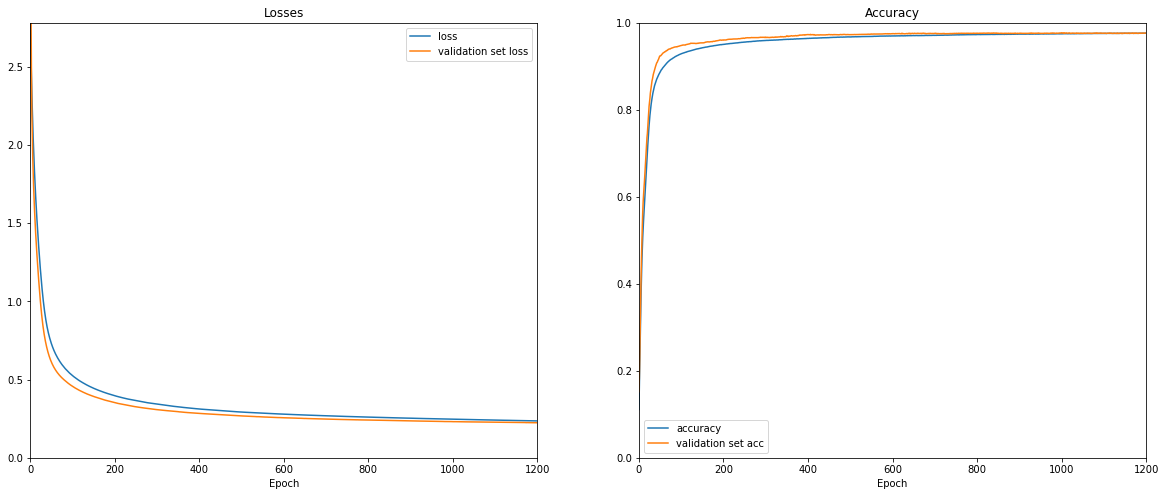

Acc:      0.9764 Loss:      0.2357
Dev-Acc:  0.9770 Dev-Loss:  0.2239
Seconds:  419.48
Estimate:  419.83


In [6]:
model = Sequential()

# Layer 1
model.add(BatchNormalization(input_shape=(N_pixels,)))
model.add(Dense(units=layerdata[0], 
                kernel_regularizer=l2(lamda),
                #bias_regularizer=l2(lamda),                
                kernel_initializer=glorot_uniform(seed=seed),
                bias_initializer=zeros()))

model.add(Activation(activation_func))

# Layers from 2 to N-1
for u in layerdata[1:]:
    model.add(Dense(units=u, 
                    kernel_regularizer=l2(lamda),
                    #bias_regularizer=l2(lamda),                
                    kernel_initializer=glorot_uniform(seed=seed),
                    bias_initializer=zeros()))

    model.add(Activation(activation_func))
    
# Output layer
model.add(Dense(
        units=10,
        kernel_regularizer=l2(lamda),
        #bias_regularizer=l2(lamda),                
        kernel_initializer=glorot_uniform(seed=seed),
        bias_initializer=zeros()
        ))

model.add(Activation('softmax'))


# Train the model
model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

init_plot(epochs)

callbacks = [callback_plot, LearningRateCallBack(lrarr)]

if logdata:
    tbCallBack = keras.callbacks.TensorBoard(
        log_dir=f'./log/{ctime()}', 
        batch_size=batch,
        histogram_freq=1, 
        write_graph=True, 
        write_images=False)
    callbacks.append(tbCallBack)


history = model.fit(X_train, Y_train, 
                    validation_data=[X_dev,Y_dev],
                    epochs=epochs, 
                    batch_size=batch, 
                    callbacks=callbacks,
                    verbose=0, 
                    shuffle=True)


### Evaluate the test set

In [7]:
result = model.evaluate(X_test, Y_test, batch_size=batch, verbose=0)
print(f"The accuracy for the test set is {result[1]:8.3f}")

The accuracy for the test set is    0.953


### Check an image

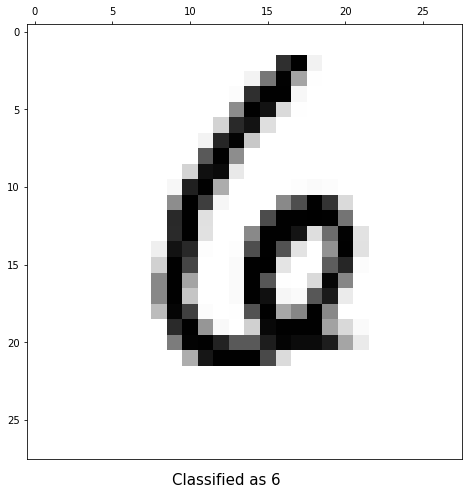

In [8]:
index = 123

imgshow(X_test,Y_test, index)

### Get the prediction

In [9]:
prediction = np.argmax(model.predict(X_test[index].reshape([1,N_pixels])))
print(f'The prediction for this image is {prediction}')

The prediction for this image is 6
